In [1]:
import domain_adapt_run.domain_adapt_run.constants as constants
cache_folder_name = 'sufficient_dimension_reduction'
seed = 42

In [2]:
import numpy as np
np.random.seed(seed)
import python_utils.python_utils.basic as basic
import python_utils.python_utils.caching as caching
log_folder = '%s/%s' % (constants.cache_folder, cache_folder_name)
caching.init(constants.cache_folder, constants.which_hash, basic.archiver(log_folder))
%load_ext autoreload
%autoreload 2

[Errno 17] File exists: '/Users/fultonw/Documents/projects/runs/domain_adapt_run/cache/sufficient_dimension_reduction'


In [3]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats
import cvxopt

* specify dimension of X, Z
* specify data: specify Prob_x, W such that z=Wx, Prob_y|z
* generate data
* plot y vs z, y vs x
* specify kernel(z,y) constructor(takes in (z,y)'s

In [4]:
# specify dimension of X,Z
x_dim = 2
z_dim = 1
y_dim = 1 # code will assume this

In [5]:
# fxn to orthonormalize W (rows are basis vectors)
def ortho(rs):
    assert rs.shape[0] == 1
    return rs / np.linalg.norm(rs[0,:])

In [6]:
# specify data distributions

# p_x
#p_x = scipy.stats.multivariate_normal(mean=np.zeros(shape=x_dim))
#p_x = scipy.stats.uniform(loc=np.zeros(shape=x_dim)
#p_x_pdf = p_x.pdf
p_x_sample = lambda : np.random.uniform(size=x_dim)
#p_x_sample = lambda : np.array(np.random.uniform(size=x_dim)<0.5,dtype=int)
#p_x_sample = lambda : np.zeros(shape=x_dim)

# W
W = ortho(np.array([[1.,0.]]))

# p_y_given_z
f_z = lambda z: 1*np.ones(z_dim).dot(z)
y_var = 0.002
p_y_noise = scipy.stats.multivariate_normal(mean=np.zeros(shape=y_dim),cov=np.eye(y_dim)*y_var)
p_y_given_z_pdf = lambda y,z: p_y_noise.pdf(y-z)
p_y_given_z_sample = lambda z: f_z(z) + p_y_noise.rvs()
#p_y_given_z_sample = lambda z: z
def mix():
    if np.random.uniform()>0.3:
        return scipy.stats.multivariate_normal(mean=np.ones(shape=y_dim)*10.,cov=np.eye(y_dim)*y_var).rvs()
    else:
        return scipy.stats.multivariate_normal(mean=np.ones(shape=y_dim)*-10.,cov=np.eye(y_dim)*y_var).rvs()
#p_y_given_z_sample = lambda z: f_z(z) + mix()

In [7]:
# specify number of data to generate
num_data = 50

In [8]:
# generate data
xs = np.array([p_x_sample() for i in xrange(num_data)])
zs = xs.dot(W.T)
ys = np.array([p_y_given_z_sample(z) for z in zs])

In [9]:
# define generic function plotter
def scatter(xs, ys, plot_dim=0):
    xs, ys = np.array(xs), np.array(ys)
    fig, ax = plt.subplots()
    plot_xs = xs if len(xs.shape)==1 else xs[:,plot_dim]
    ax.scatter(plot_xs, ys)
    basic.display_fig_inline(fig)
    
def scatter_3d(xs, ys, zs):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs,ys,zs,s=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    basic.display_fig_inline(fig)

In [10]:
# hyperparameters
reg_lambda = .01

In [11]:
# define some constants for plotting
xs_plot_dim_1 = 0
xs_plot_dim_2 = 1
plot_zs = zs
W_z = np.array([[1.]])
plot_1d_zs = plot_zs.dot(W_z.T)
plot_ys = ys
color_wheel = itertools.cycle(['c','b','k','g'])

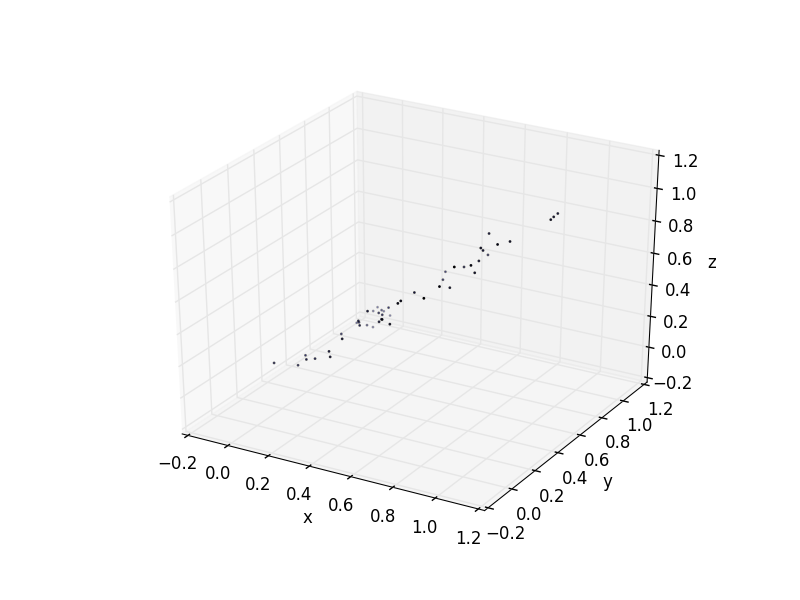

In [12]:
# plot data, 3d
scatter_3d(xs[:,xs_plot_dim_1],xs[:,xs_plot_dim_2],ys)

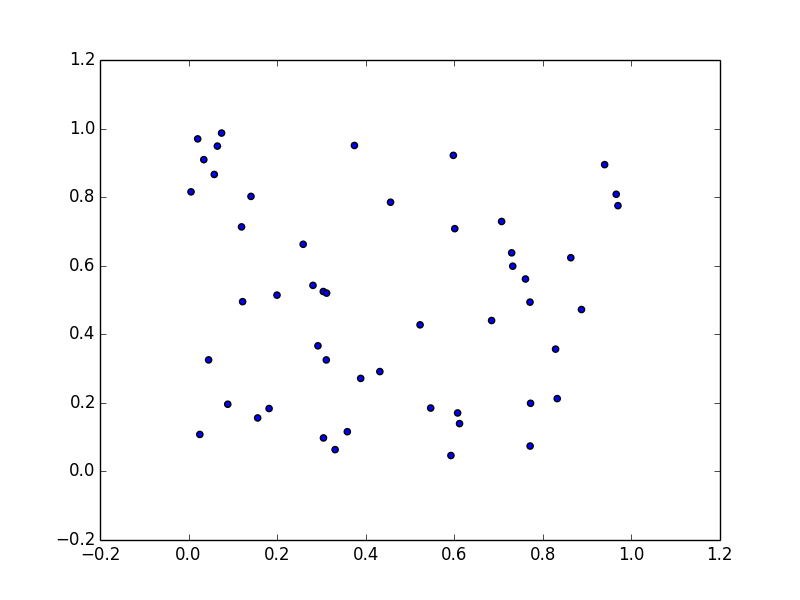

In [13]:
# plot xs, 2d
scatter(xs[:,xs_plot_dim_1],xs[:,xs_plot_dim_2])

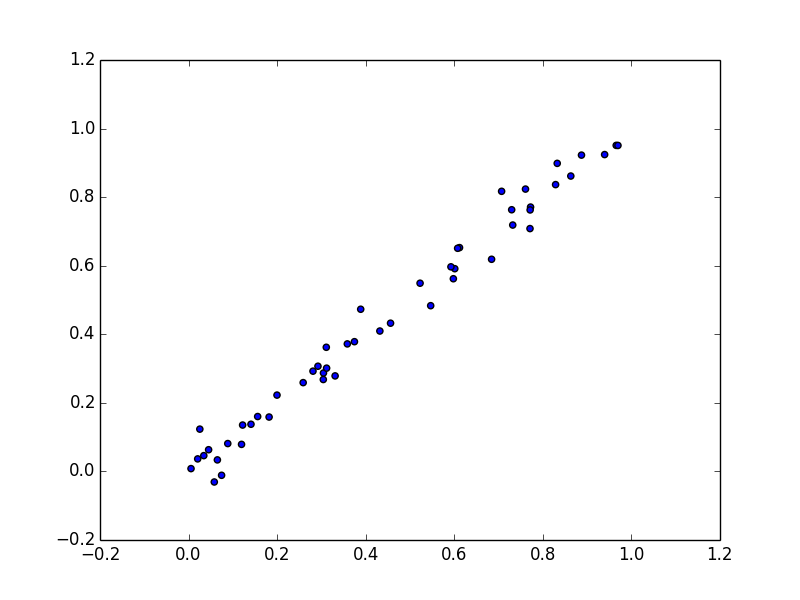

In [14]:
# plot data, 2d
scatter(zs[:,0],ys)

In [15]:
# define kernel function constructors
from collections import namedtuple

class gaussian_kerf(object):
    def __init__(self, scale, center):
        self.center, self.scale = center, scale
    def val(self, x):
        return np.exp( - np.linalg.norm(x-self.center) / (2*(self.scale**2)) )
    
class epan_kerf(object):
    def __init__(self, scale, center):
        self.center, self.scale = center, scale
    def val(self, x):
        return max(0, 1-(np.linalg.norm(x-self.center)/ (2*(self.scale**2))))

class delta_kerf(object):
    def __init__(self,x):
        self.x = x
    def val(self, x):
        return int(x == self.x)

class zy_kerf(namedtuple('zy_kerf',['z_kerf','y_kerf'])):
    # fxn that is product of 2 fxns
    def z_val(self,z):
        return self.z_kerf.val(z)
    def y_val(self,y):
        return self.y_kerf.val(y)
    def val(self, (z,y)):
        return self.z_val(z) * self.y_val(y)

class kerf_basis(object):
    # vectorized fxn
    def __init__(self, kerfs):
        self._kerfs = kerfs
    @property
    def kerfs(self):
        return self._kerfs
    def __len__(self):
        return len(self.kerfs)
    def val(self, x):
        return np.array(map(lambda kerf: kerf.val(x), self.kerfs))

class zy_kerf_basis(kerf_basis):
    # takes in 2 vector fxns, creates fxn that returns element-wise product 
    def z_val(self, z):
        return np.array(map(lambda zy_kerf:zy_kerf.z_val(z),self.kerfs))
    def y_val(self, y):
        return np.array(map(lambda zy_kerf:zy_kerf.y_val(y),self.kerfs))

class lincomb_kerf(object):
    def __init__(self, alpha, basis):
        self.alpha, self.basis = alpha, basis
    def z_val(self,z):
        return self.alpha.dot(self.basis.z_val(z))
    def y_val(self,y):
        return self.alpha.dot(self.basis.y_val(y))
    def val(self, x):
        #print zip(self.basis.val(x), self.alpha)
        #fig,ax = plt.subplots()
        #ax.hist(self.basis.val(x))
        #basic.display_fig_inline(fig)
        #pdb.set_trace()
        ans = self.alpha.dot(self.basis.val(x))
        #print ans
        return ans

In [16]:
# has to be specified, so do it globally
scale_z_ratio = 1.

In [17]:
# define fxn that takes in zys, return basis fxn
def get_basis(zs,ys):

    # specify basis centers
    centers = zip(zs,ys)#[:50]
    #centers = [(np.array([0]),0),(np.array([0]),1),(np.array([1]),0),(np.array([1]),1)]

    # specify center-based constructors
    scale_y_ratio = .5
    scale_z = scale_z_ratio * np.median([np.linalg.norm(z_i-z_j) for z_i in zs for z_j in zs])
    scale_y = scale_y_ratio * np.median([np.linalg.norm(y_i-y_j) for y_i in ys for y_j in ys])
    #z_cons = delta_kerf
    #z_cons = functools.partial(gaussian_kerf, scale_z)
    z_cons = functools.partial(epan_kerf, scale_z)
    #y_cons = delta_kerf
    y_cons = functools.partial(gaussian_kerf, scale_y)
    return zy_kerf_basis(map(lambda(z,y): zy_kerf(z_cons(z),y_cons(y)), centers))

In [18]:
# get basis
true_zs_zy_kerf_basis = get_basis(zs,ys)

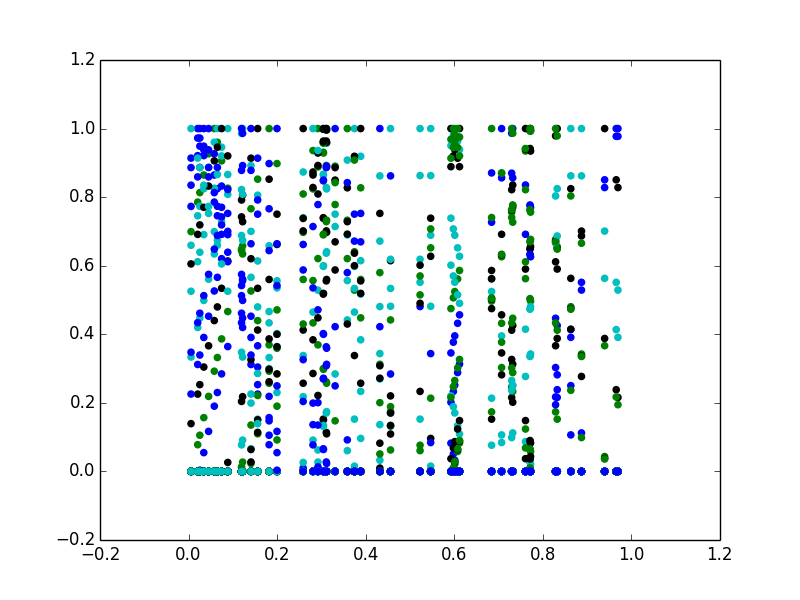

In [19]:
# for true zs, plot several z kernel functions
fig, ax = plt.subplots()
for (kerf,color) in itertools.izip(true_zs_zy_kerf_basis.kerfs, color_wheel):
    ax.scatter(plot_1d_zs, map(kerf.z_val,plot_1d_zs), color=color)
basic.display_fig_inline(fig)

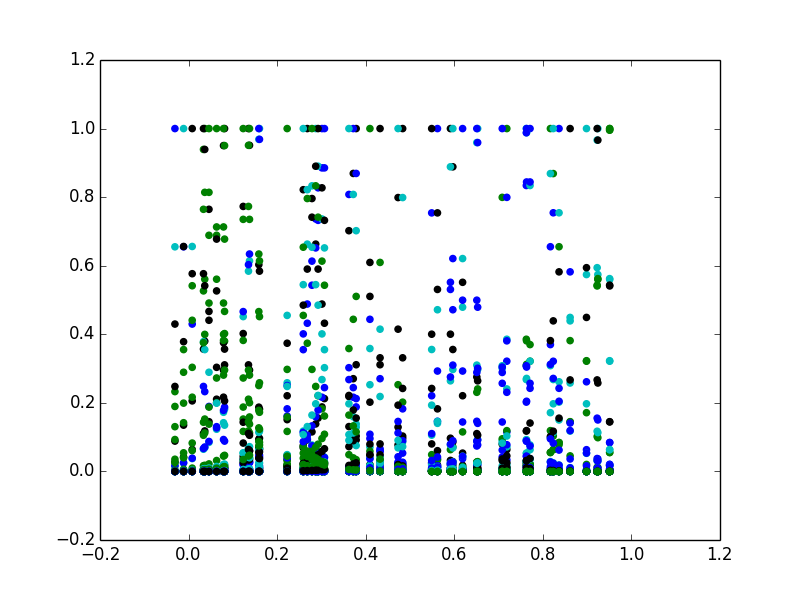

In [20]:
# plot several y kernel functions
fig, ax = plt.subplots()
for (y_kerf,color) in itertools.izip(true_zs_zy_kerf_basis.kerfs, color_wheel):
    ax.scatter(plot_ys, map(y_kerf.y_val,plot_ys), color=color)
basic.display_fig_inline(fig)

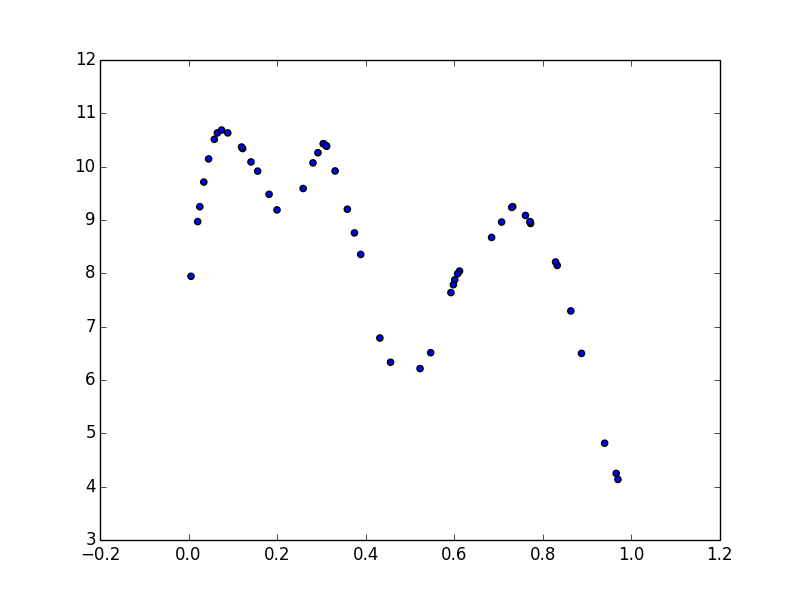

In [21]:
#  for true zs, create a z_fxn based on basis plot
alpha = np.ones(len(true_zs_zy_kerf_basis))
true_zs_a_fxn = lincomb_kerf(alpha, true_zs_zy_kerf_basis)
scatter(plot_1d_zs, map(true_zs_a_fxn.z_val,plot_zs))

In [22]:
#
def alpha_argmax(basis, reg_lambda, zs, ys):
    # returns alpha and obj value, which approximates squared mutual information
    zys = zip(zs,ys)
    N = float(len(zys))
#    for zy_i in zys:
#        for zy_j in zys:
#            print basis.val(zy_i), basis.val(zy_j)
#            print np.outer(basis.val(zy_i),basis.val(zy_j))
#    pdb.set_trace()
    H = np.sum(np.array([np.outer(basis.val((z,y)), basis.val((z,y))) for z in zs for y in ys]), axis=0) / (N**2)
    P = H + (reg_lambda*np.eye(len(basis)))
    #print H
    h = - np.sum([basis.val(zy_i) for zy_i in zys], axis=0) / N
    P_inv = np.linalg.inv(P)
    alpha_analytic = P_inv.dot(-h)
    q = h
    #print [basis.val(zy_i) for zy_i in zys]
    #print "ok"
    #print H
    #print h
    ans = cvxopt.solvers.qp(\
                            cvxopt.matrix(P,tc='d'),\
                            cvxopt.matrix(q,tc='d'),\
                            )
    #print ans
    alpha = np.array(ans['x'])[:,0]
    #print zip(alpha,alpha_analytic)
    obj_val = ans['primal objective']
    print -obj_val, -0.5*h.dot(alpha_analytic)
    return alpha, -obj_val

2.1528079563 2.1528079563
true_zs_MI: 2.1528079563


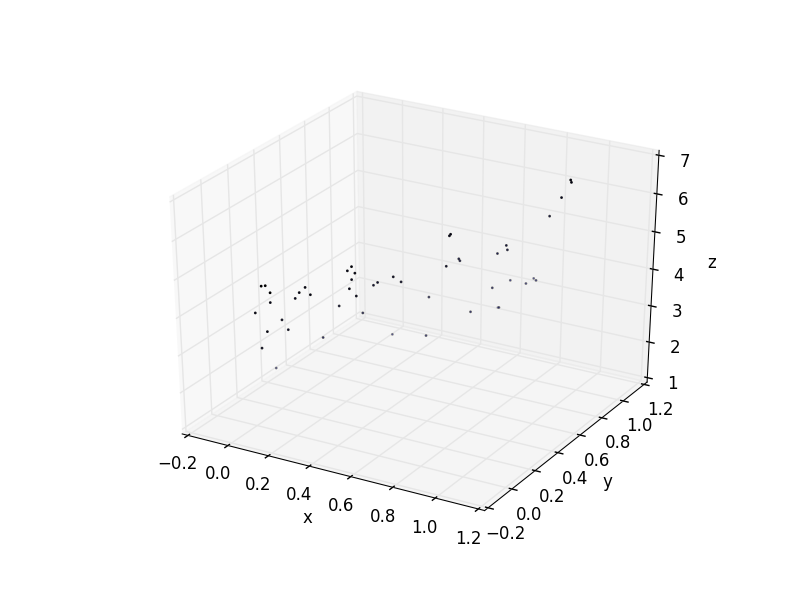

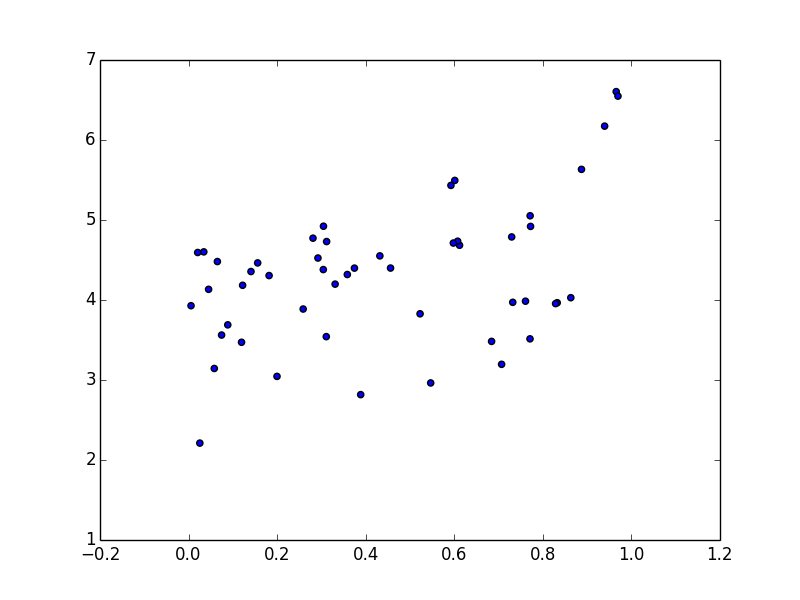

In [23]:
# for true zs, estimate, plot ratio function
true_zs_alpha, true_zs_MI = alpha_argmax(true_zs_zy_kerf_basis, reg_lambda, zs, ys)
#print 'true_zs_alpha:', true_zs_alpha
print 'true_zs_MI:', true_zs_MI
true_zs_ratio_fxn = lincomb_kerf(true_zs_alpha, true_zs_zy_kerf_basis)
scatter_3d(plot_1d_zs, plot_ys, map(true_zs_ratio_fxn.val,zip(plot_zs,plot_ys)))
scatter(plot_1d_zs, map(true_zs_ratio_fxn.val,zip(plot_zs,plot_ys)))

1.2144111143 1.2144111143
trial 0
rand_W: [[-0.77387857  0.633334  ]]
dot with true_W: [[-0.77387857]]
rand_zs_MI: 1.2144111143


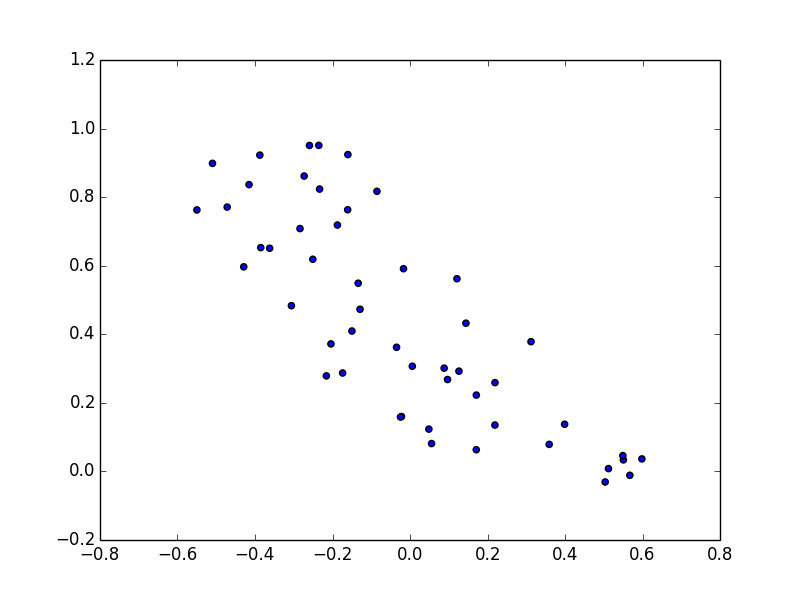

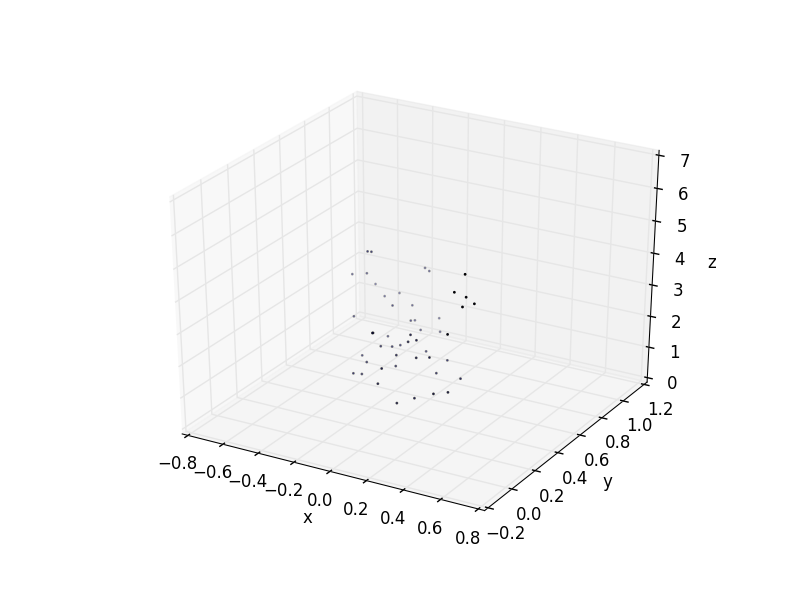

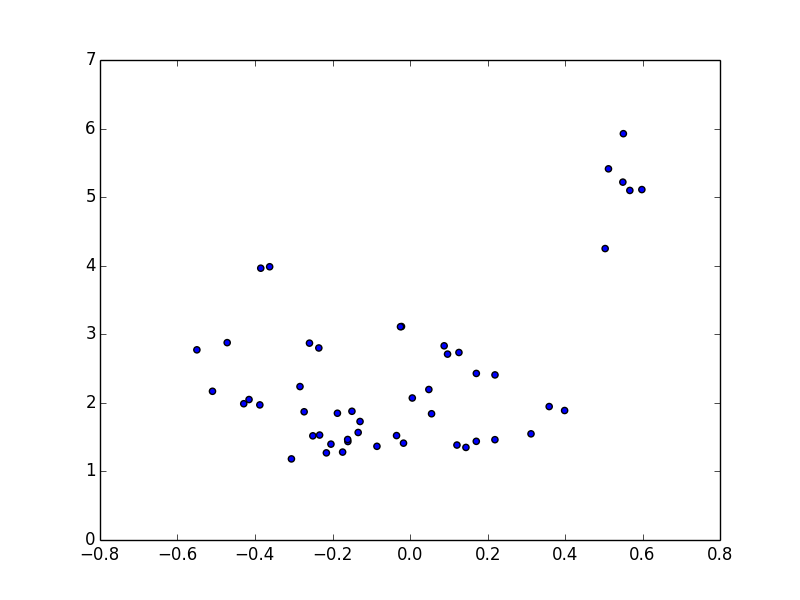

1.11611953594 1.11611953594
trial 1
rand_W: [[-0.49632192 -0.86813855]]
dot with true_W: [[-0.49632192]]
rand_zs_MI: 1.11611953594


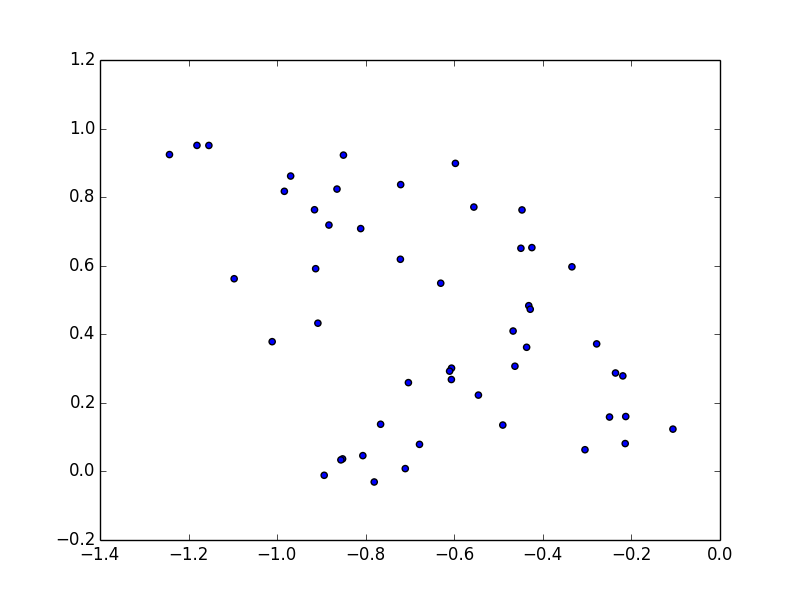

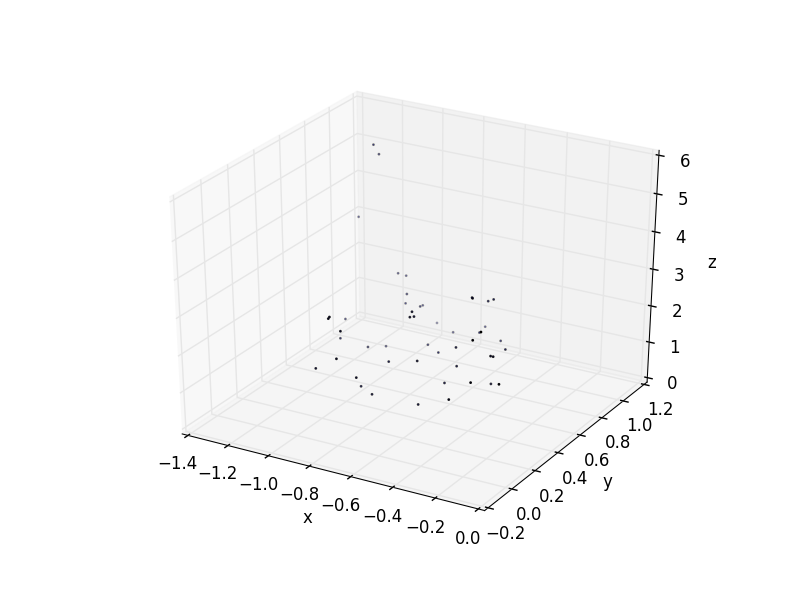

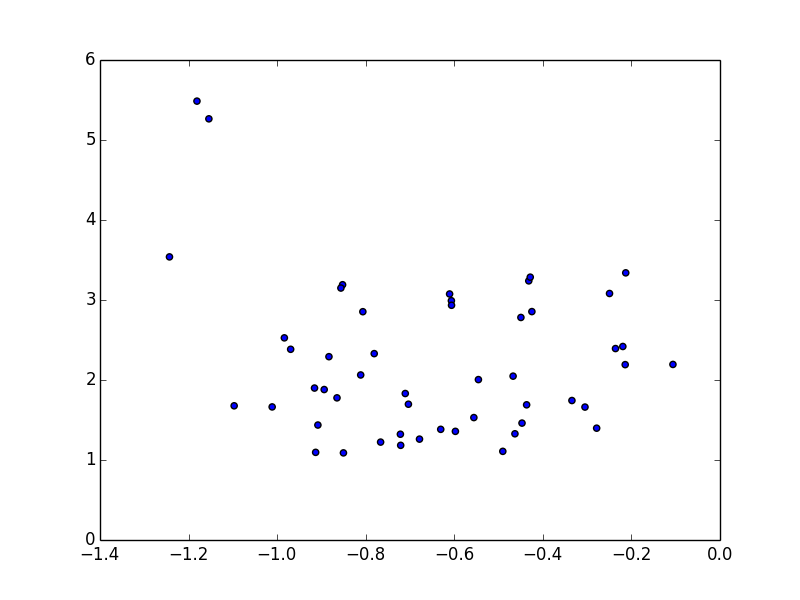

1.90895703666 1.90895703666
trial 2
rand_W: [[-0.98096982  0.19416029]]
dot with true_W: [[-0.98096982]]
rand_zs_MI: 1.90895703666


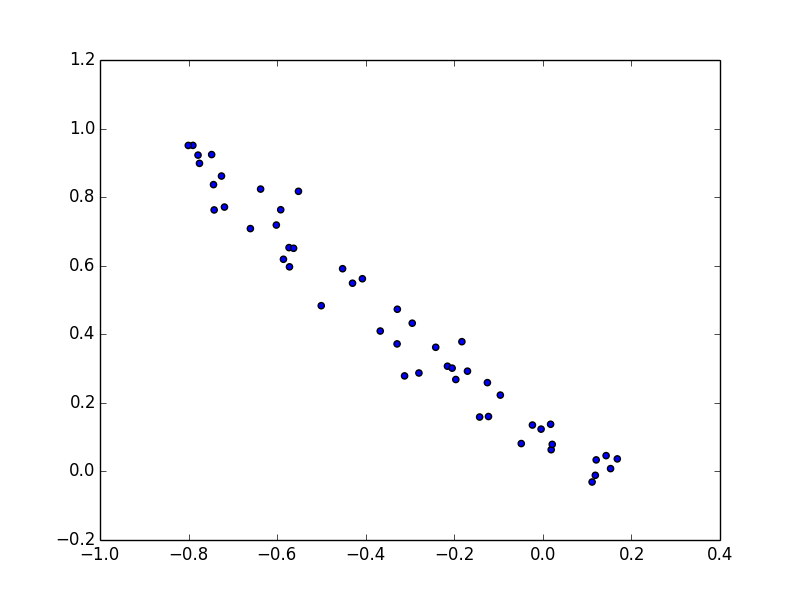

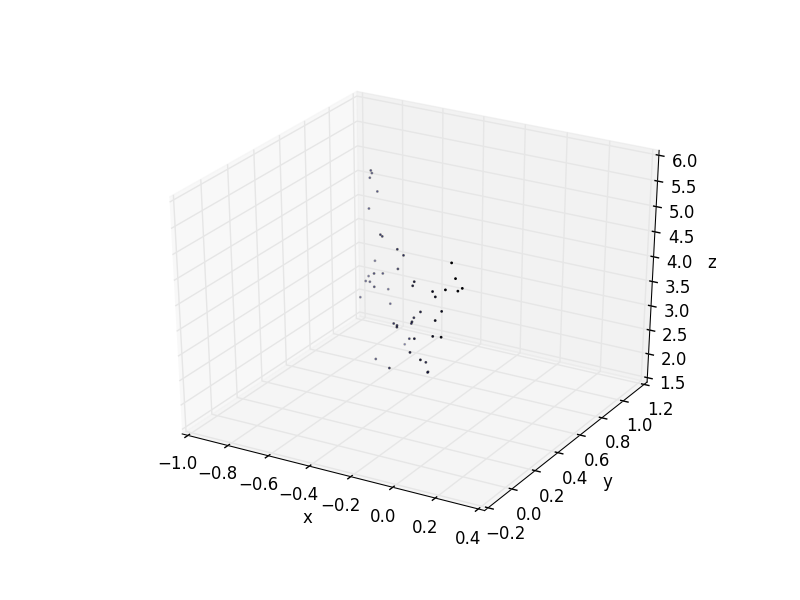

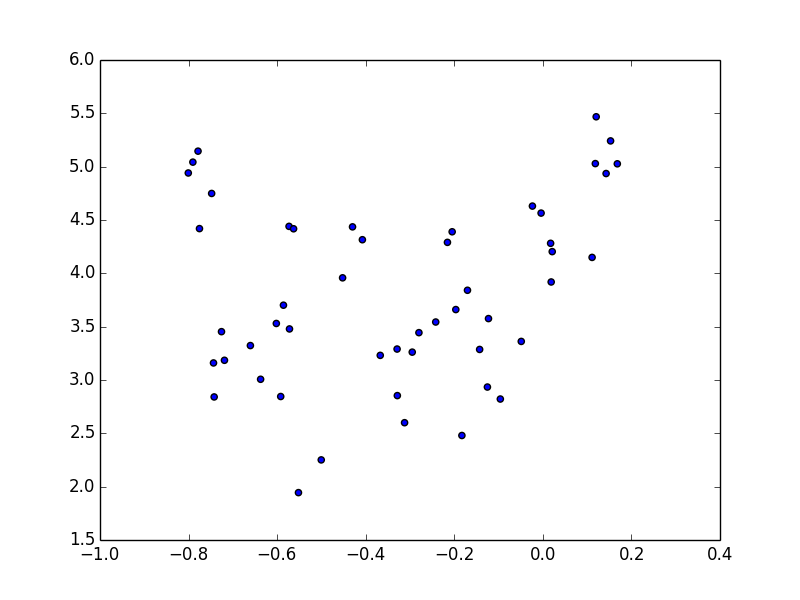

1.07720154921 1.07720154921
trial 3
rand_W: [[ 0.34479074 -0.93867958]]
dot with true_W: [[ 0.34479074]]
rand_zs_MI: 1.07720154921


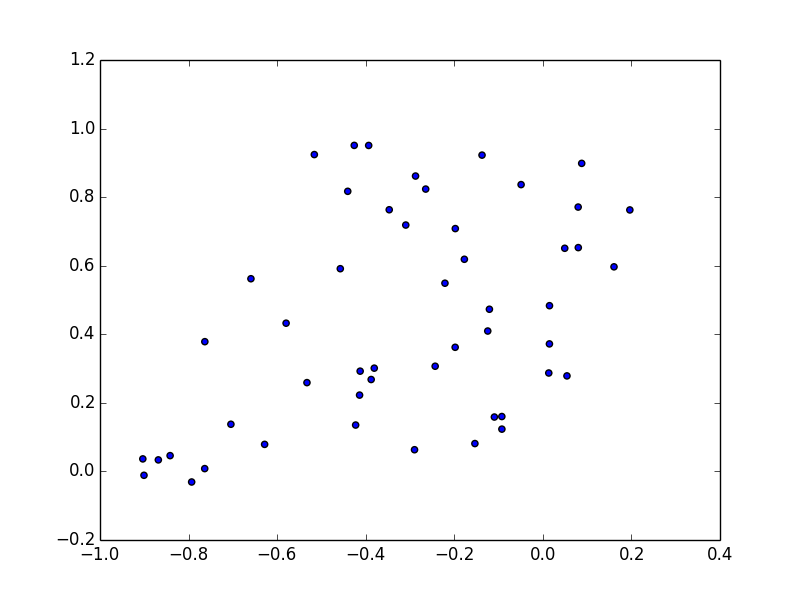

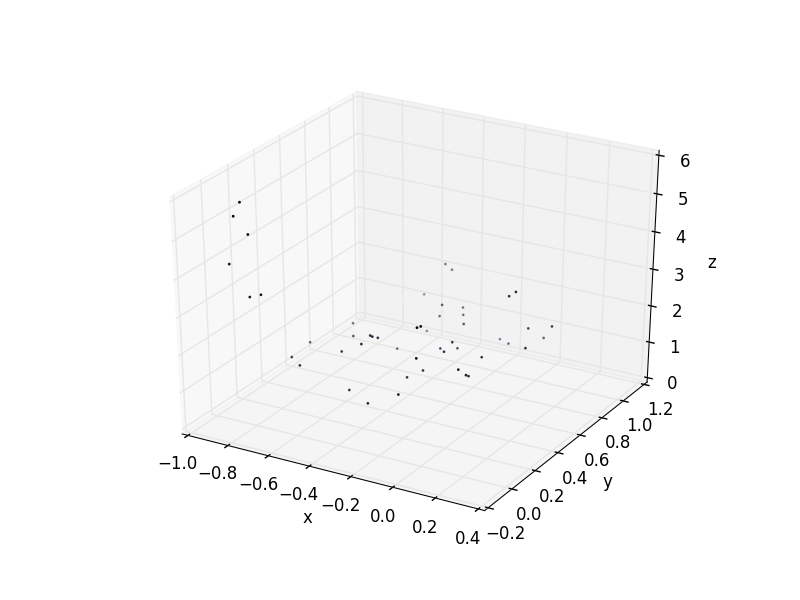

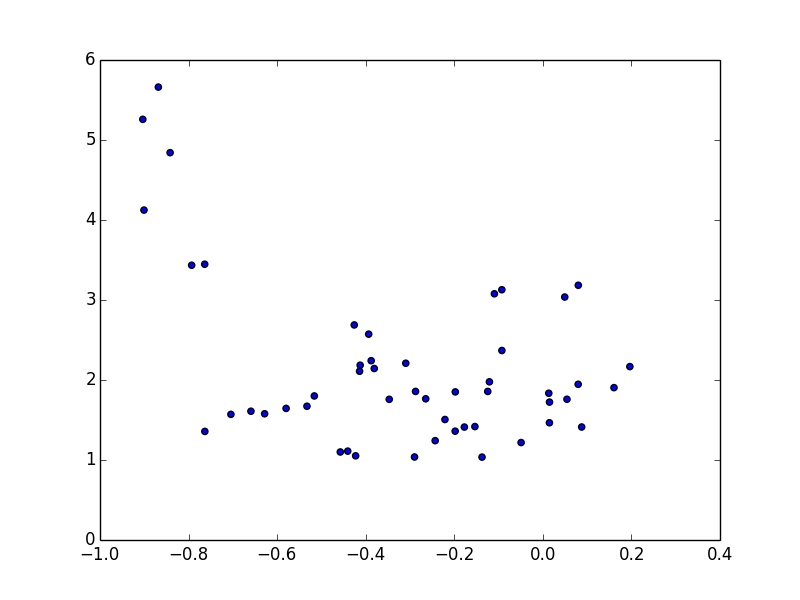

1.00497800914 1.00497800914
trial 4
rand_W: [[ 0.0441721  -0.99902394]]
dot with true_W: [[ 0.0441721]]
rand_zs_MI: 1.00497800914


/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


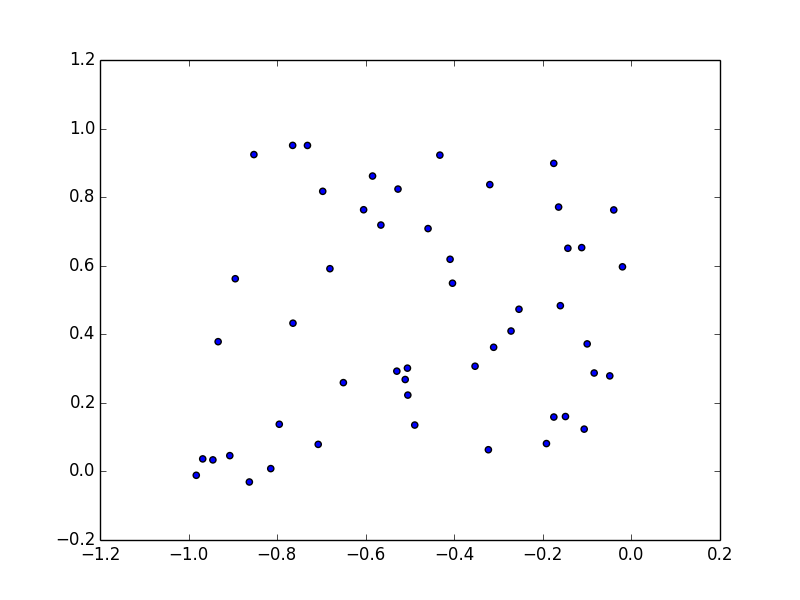

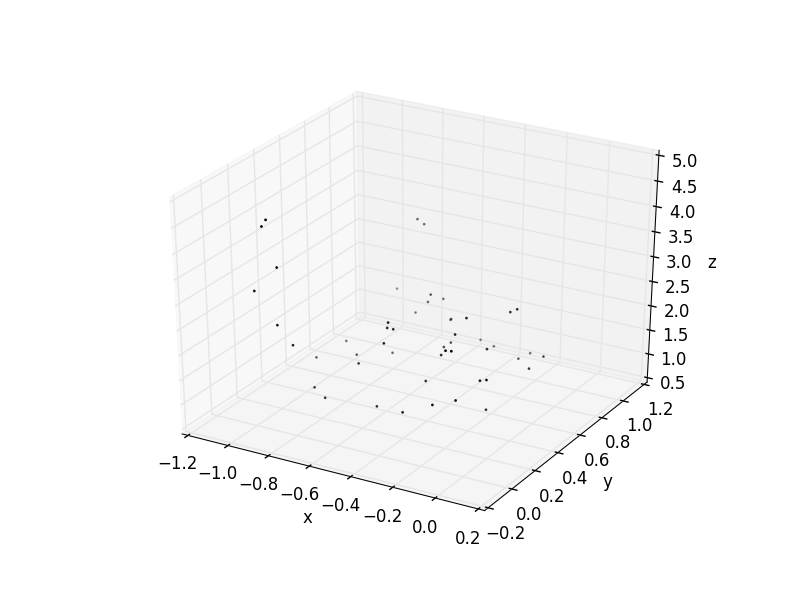

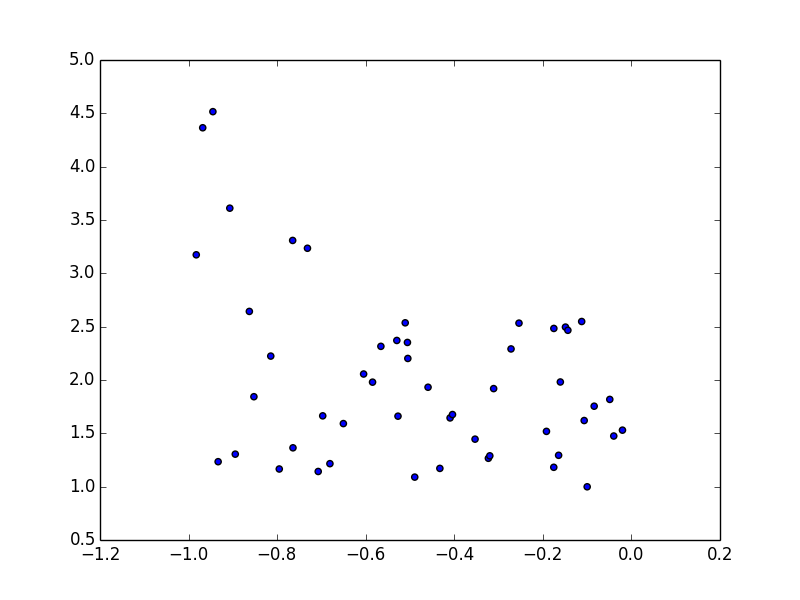

In [24]:
# for randomly generated W that gives z:
# calculate z, plot plot_1d_z vs y, generate z-based basis
num_trials = 5

def random_W():
    #return np.array([[0.,1.]])
    return ortho(np.random.uniform(low=-1.0,high=1.0,size=(z_dim,x_dim)))

for i in xrange(num_trials):
    rand_W = random_W()
    rand_zs = xs.dot(rand_W.T)

    rand_zs_zy_kerf_basis = get_basis(rand_zs,ys)

    rand_plot_zs = rand_zs
    rand_plot_ys = ys
    rand_plot_1d_zs = rand_zs.dot(W_z.T)
    
    
    rand_zs_alpha, rand_zs_MI = alpha_argmax(rand_zs_zy_kerf_basis, reg_lambda, rand_zs, ys)
    print 'trial', i
    print 'rand_W:', rand_W
    print 'dot with true_W:', rand_W.dot(W.T)
    #print 'rand_zs_alpha:', rand_zs_alpha
    print 'rand_zs_MI:', rand_zs_MI
    scatter(rand_plot_1d_zs,ys)
    rand_zs_ratio_fxn = lincomb_kerf(rand_zs_alpha, rand_zs_zy_kerf_basis)
    scatter_3d(rand_plot_1d_zs, rand_plot_ys, map(rand_zs_ratio_fxn.val,zip(rand_plot_zs,rand_plot_ys)))
    scatter(rand_plot_1d_zs, map(rand_zs_ratio_fxn.val,zip(rand_plot_zs,rand_plot_ys)))

In [28]:
# improve W
def improve_W(alpha, zs_zy_kerf_basis, zs, xs, ys):
    _z_scale = iter(zs_zy_kerf_basis.kerfs).next().z_kerf.scale
    components = []
    for (z_i,x_i,y_i) in itertools.izip(zs,xs,ys):
        ind_i = np.array(zs_zy_kerf_basis.z_val(z_i)>0,dtype=int)
        L_i = zs_zy_kerf_basis.y_val(y_i)
        mat_i = [(np.eye(x_dim)/float(z_dim)) - (np.outer(x_i-x_j,x_i-x_j)/(2*(_z_scale**2))) for x_j in xs]
        ans_i = np.sum([ind_ij*L_ij*mat_ij for (ind_ij,L_ij,mat_ij) in itertools.izip(ind_i,L_i,mat_i)], axis=0)
        components.append(ans_i)
        #pdb.set_trace()
    D = np.sum(components, axis=0) / len(ys)
    U,S,D = np.linalg.svd(D)
    print U
    print S
    print D
#    pdb.set_trace()
    return U[:,:z_dim].T

1.210561301 1.210561301
trial 0
cur_W: [[ 0.76948715 -0.63866229]]
dot with true_W: [[ 0.76948715]]
cur_zs_MI: 1.210561301


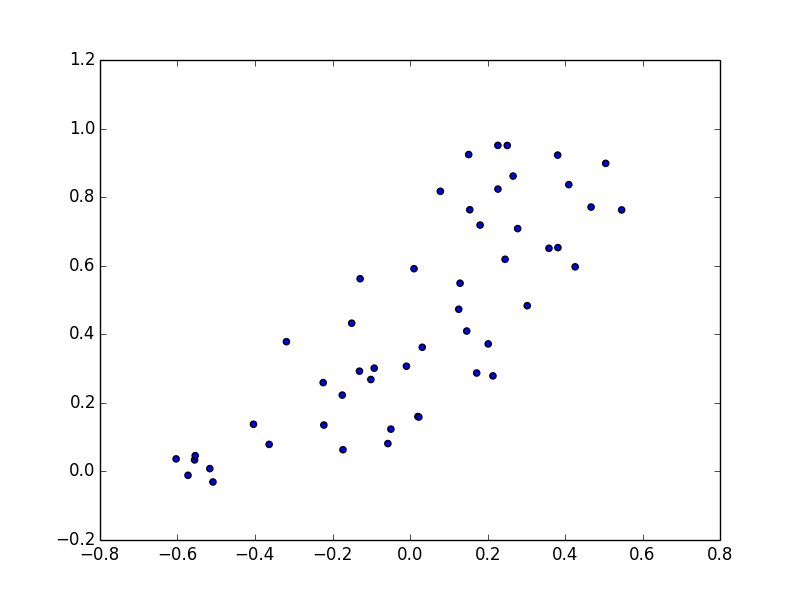

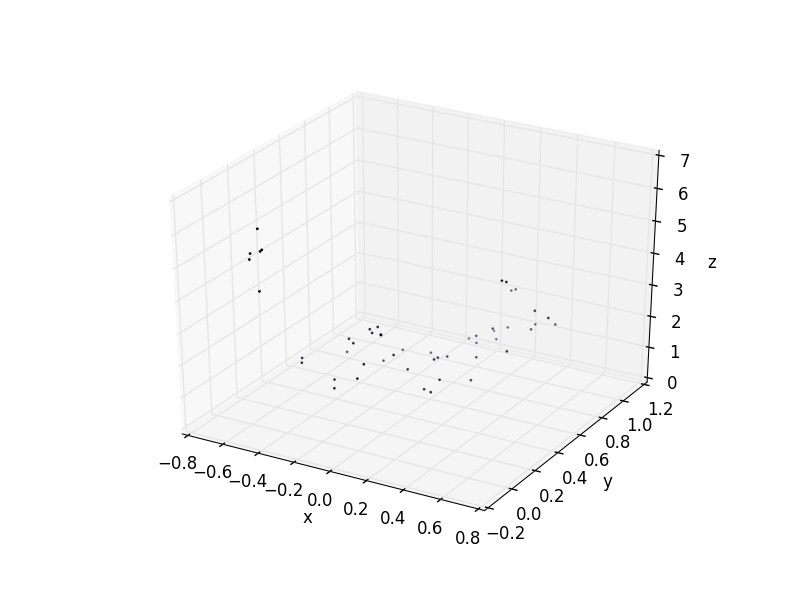

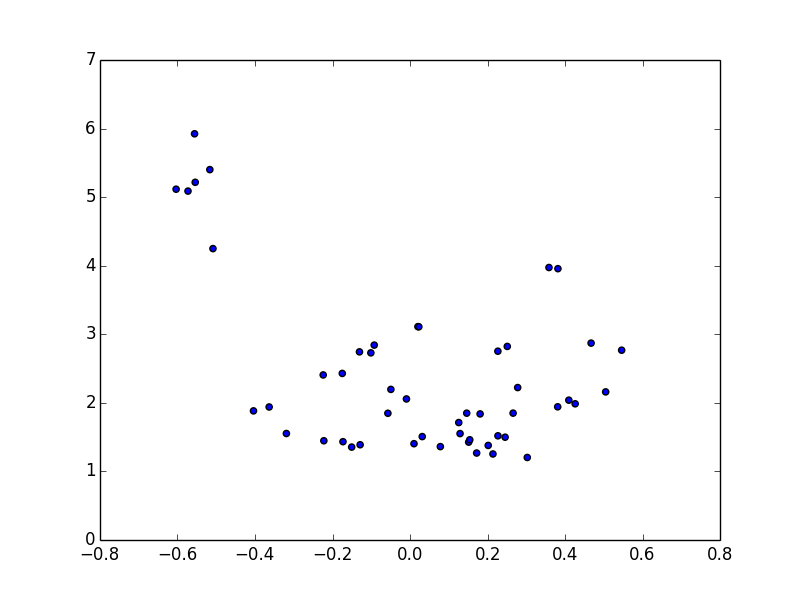

[[-0.96824269  0.2500122 ]
 [ 0.2500122   0.96824269]]
[ 2.83225367  2.55320339]
[[-0.96824269  0.2500122 ]
 [ 0.2500122   0.96824269]]
1.78153144858 1.78153144858
trial 1
cur_W: [[-0.96824269  0.2500122 ]]
dot with true_W: [[-0.96824269]]
cur_zs_MI: 1.78153144858


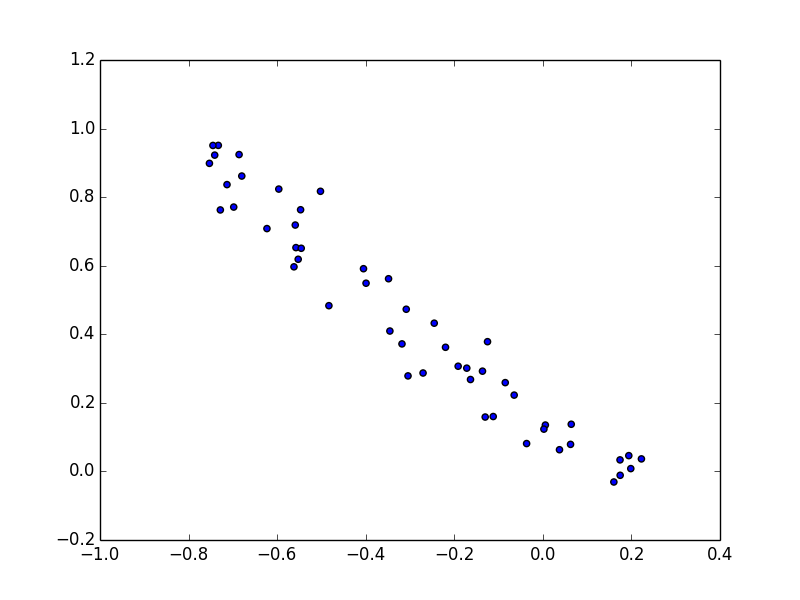

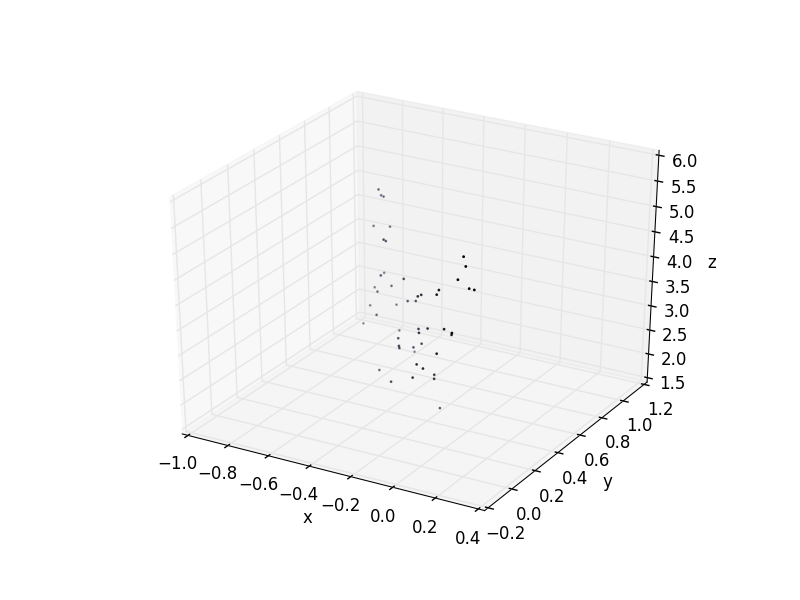

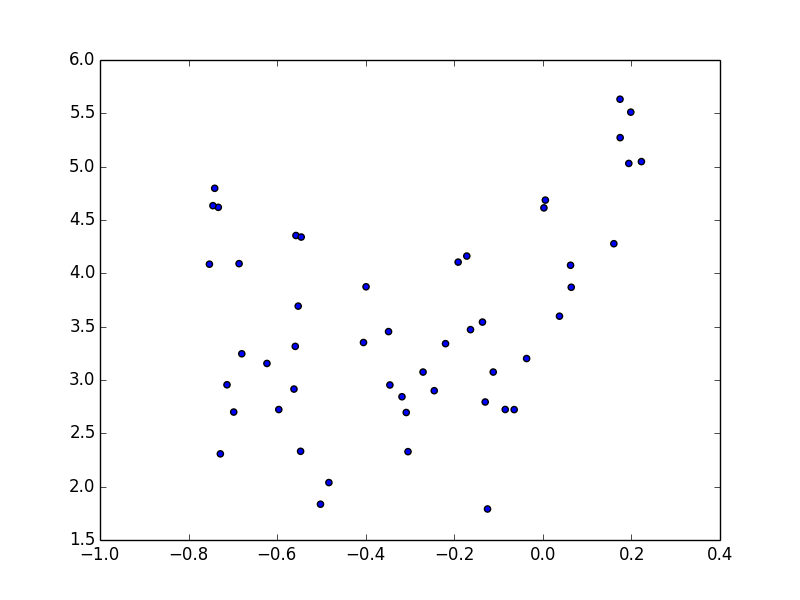

[[-0.99836804  0.05710746]
 [ 0.05710746  0.99836804]]
[ 4.32229334  2.20060868]
[[-0.99836804  0.05710746]
 [ 0.05710746  0.99836804]]
2.13070765189 2.13070765189
trial 2
cur_W: [[-0.99836804  0.05710746]]
dot with true_W: [[-0.99836804]]
cur_zs_MI: 2.13070765189


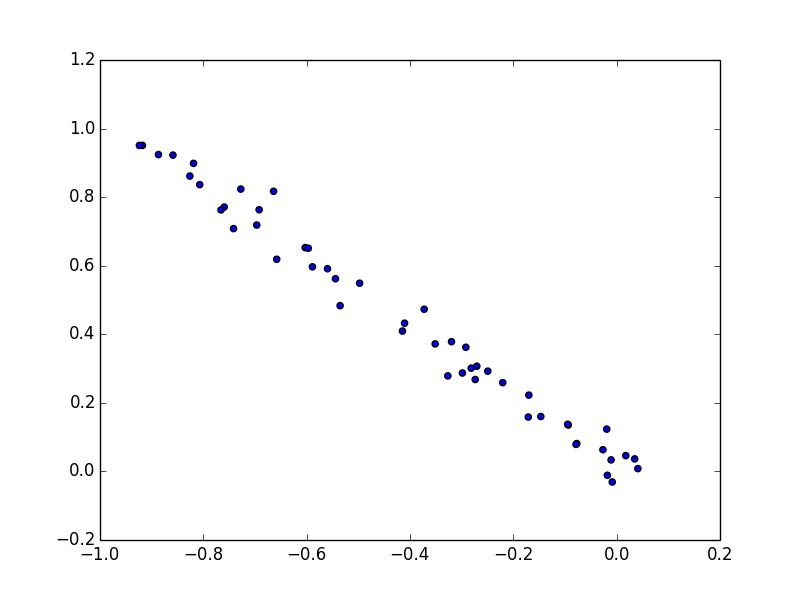

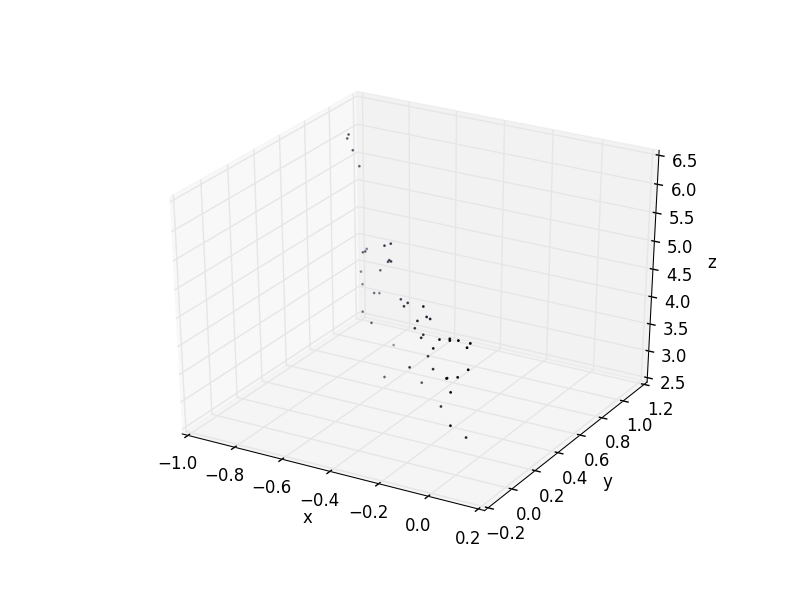

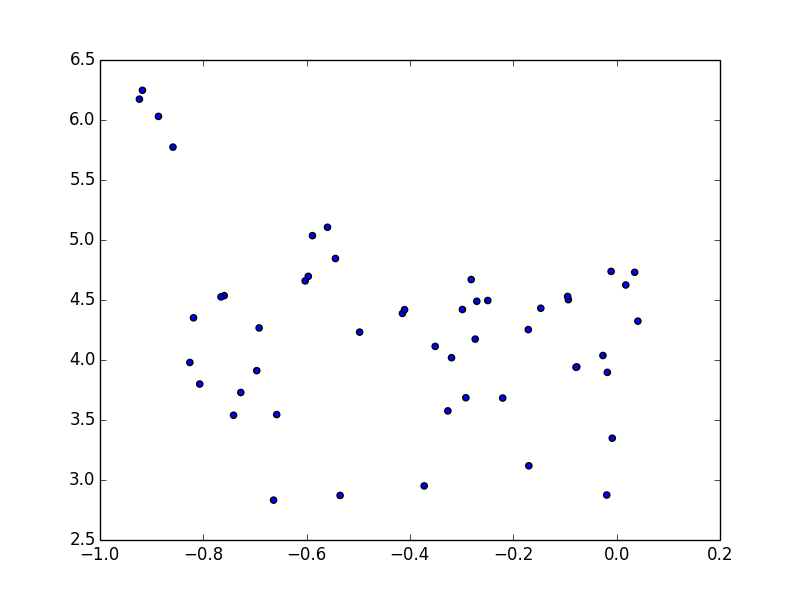

[[-0.9998918  0.0147104]
 [ 0.0147104  0.9998918]]
[ 4.59902728  1.68438769]
[[-0.9998918  0.0147104]
 [ 0.0147104  0.9998918]]
2.16046980826 2.16046980826
trial 3
cur_W: [[-0.9998918  0.0147104]]
dot with true_W: [[-0.9998918]]
cur_zs_MI: 2.16046980826


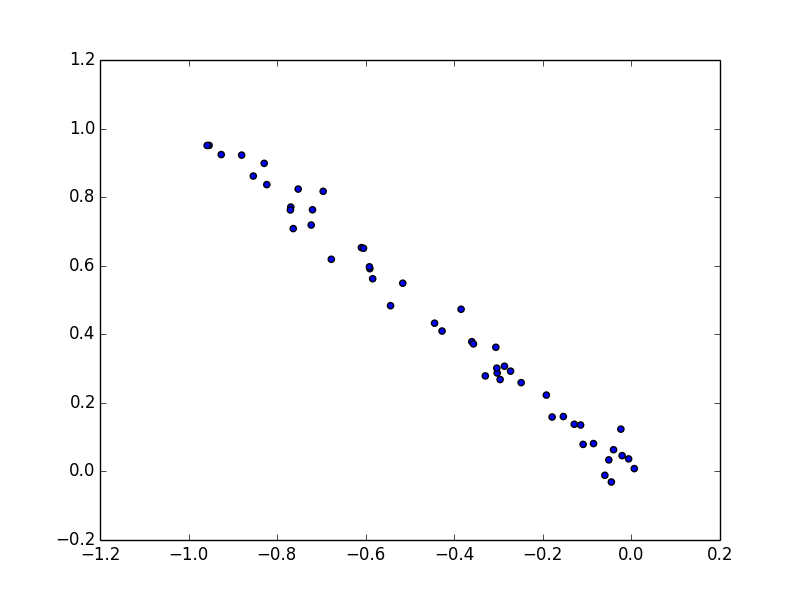

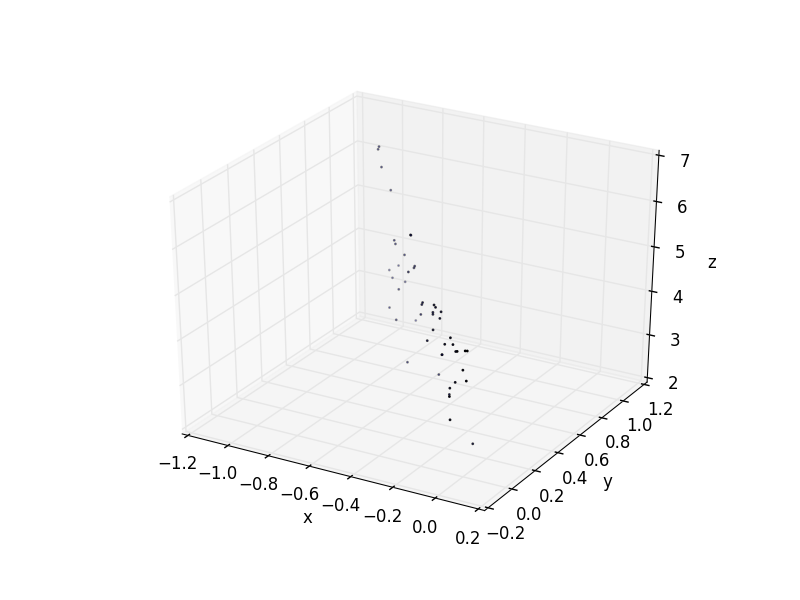

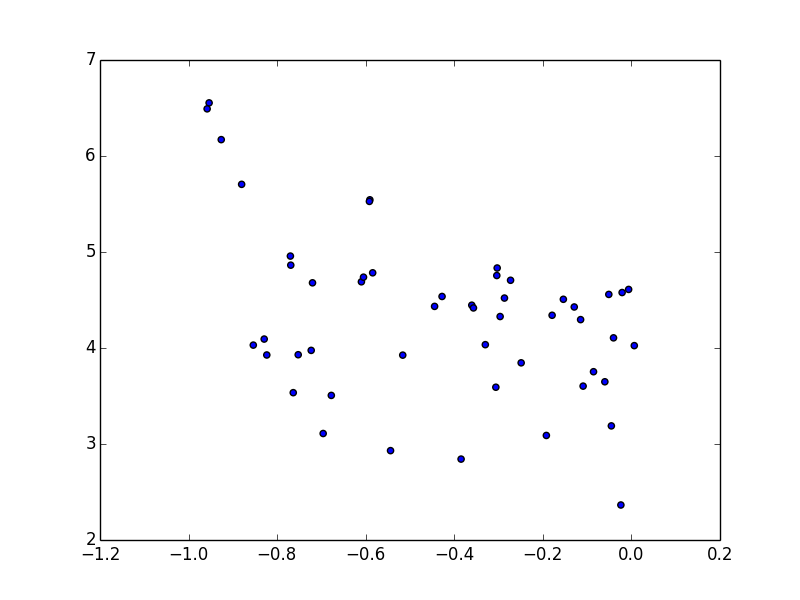

[[-0.99995206  0.00979139]
 [ 0.00979139  0.99995206]]
[ 4.58973139  1.54411652]
[[-0.99995206  0.00979139]
 [ 0.00979139  0.99995206]]
2.16219998542 2.16219998542
trial 4
cur_W: [[-0.99995206  0.00979139]]
dot with true_W: [[-0.99995206]]
cur_zs_MI: 2.16219998542


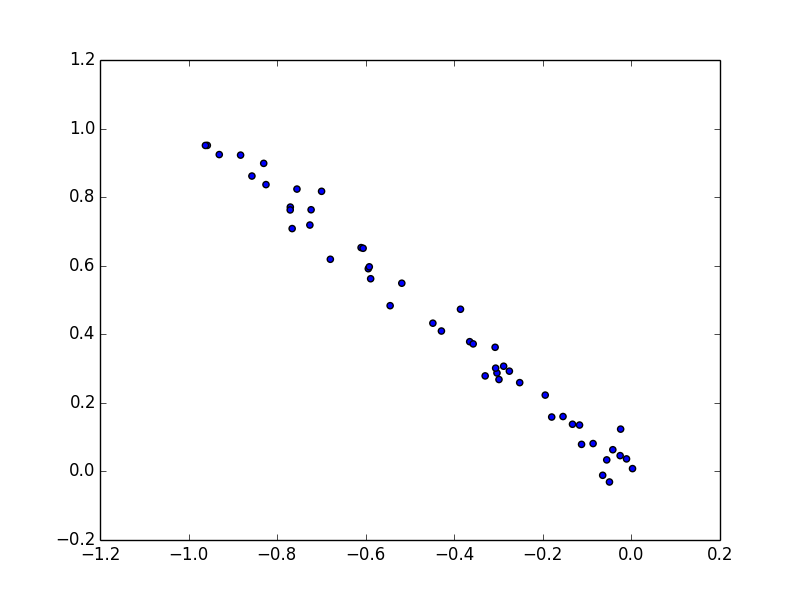

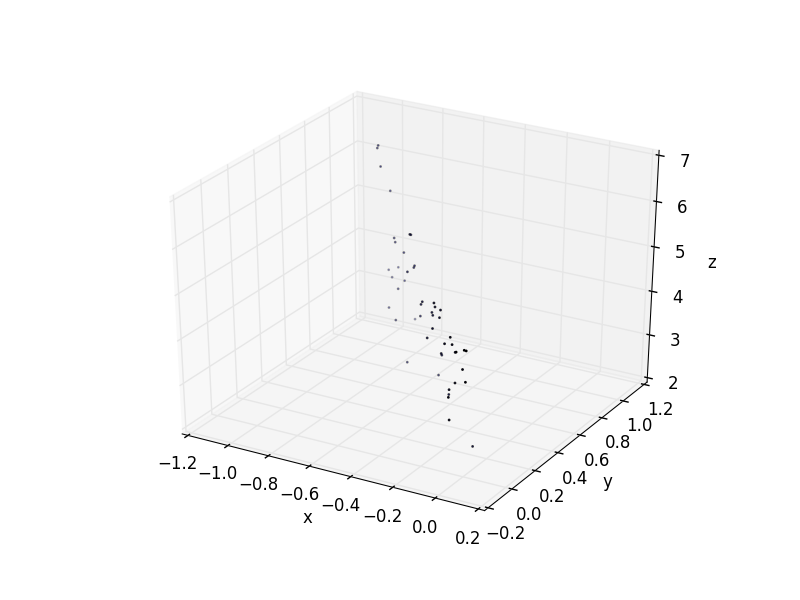

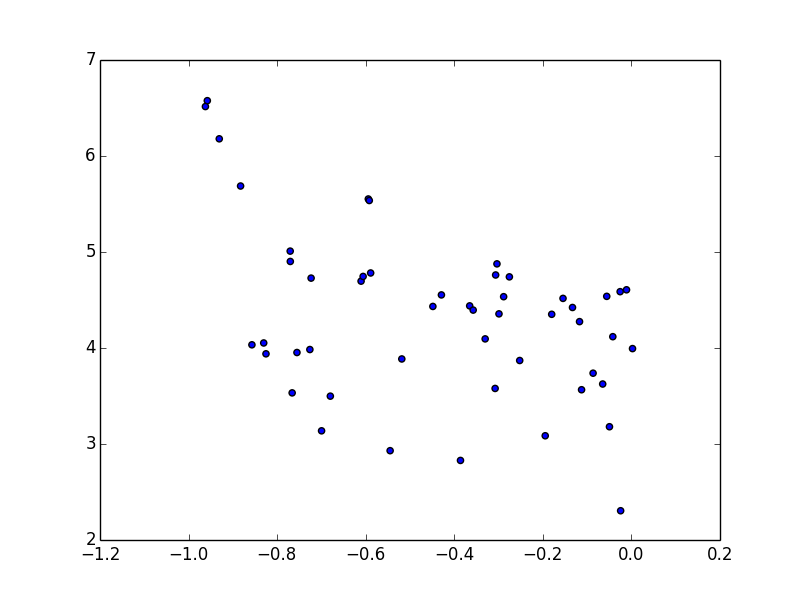

[[-0.99995681  0.00929433]
 [ 0.00929433  0.99995681]]
[ 4.5849606   1.51100346]
[[-0.99995681  0.00929433]
 [ 0.00929433  0.99995681]]


In [29]:
# 
num_iters = 5

cur_W = random_W()

for i in xrange(num_iters):
    cur_zs = xs.dot(cur_W.T)

    cur_zs_zy_kerf_basis = get_basis(cur_zs,ys)

    cur_plot_zs = cur_zs
    cur_plot_ys = ys
    cur_plot_1d_zs = cur_zs.dot(W_z.T)
    
    
    cur_zs_alpha, cur_zs_MI = alpha_argmax(cur_zs_zy_kerf_basis, reg_lambda, cur_zs, ys)
    print 'trial', i
    print 'cur_W:', cur_W
    print 'dot with true_W:', cur_W.dot(W.T)
    #print 'rand_zs_alpha:', rand_zs_alpha
    print 'cur_zs_MI:', cur_zs_MI
    scatter(cur_plot_1d_zs,ys)
    cur_zs_ratio_fxn = lincomb_kerf(cur_zs_alpha, cur_zs_zy_kerf_basis)
    scatter_3d(cur_plot_1d_zs, cur_plot_ys, map(cur_zs_ratio_fxn.val,zip(cur_plot_zs,cur_plot_ys)))
    scatter(cur_plot_1d_zs, map(cur_zs_ratio_fxn.val,zip(cur_plot_zs,cur_plot_ys)))
    
    # update W
    cur_W = improve_W(cur_zs_alpha, cur_zs_zy_kerf_basis, cur_zs, xs, ys)